## Test the pretrained model's predictions on some noisy voices.

We are using this model: https://github.com/vbelz/Speech-enhancement

In [1]:
# constants (defined in the repo)
SAMPLE_RATE = 8000
MIN_DURATION = 1.0
FRAME_LENGTH = 8064
HOP_LENGTH_FRAME = 8064
HOP_LENGTH_FRAME_NOISE = 5000
N_FFT = 255
HOP_LENGTH_FFT = 63
DIM_SQUARE_SPEC = int(N_FFT / 2) + 1

In [2]:
from IPython import display
example_audio = "D:/for-norm/training/real/file1.wav_16k.wav_norm.wav_mono.wav_silence.wav"
display.display(display.Audio(example_audio, rate=SAMPLE_RATE))

In [3]:
import librosa
waveform, _ = librosa.load(example_audio, sr=SAMPLE_RATE)
waveform.shape

(20013,)

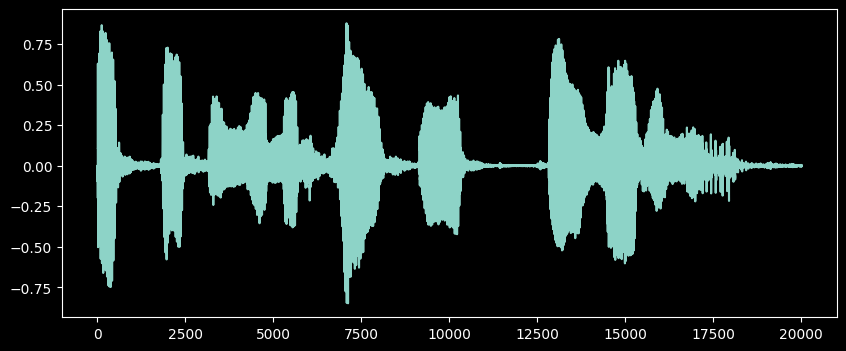

In [4]:
import matplotlib.pyplot as plt
plt.style.use("dark_background")
plt.figure(figsize=(10, 4))
plt.plot(waveform)
plt.show()

In [5]:
with open("weights/model_unet.json", "r") as json_file:
    loaded_model_json = json_file.read()

In [6]:
import tensorflow as tf
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
loaded_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_48 (Conv2D)             (None, 128, 128, 16  160         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_46 (LeakyReLU)     (None, 128, 128, 16  0           ['conv2d_48[0][0]']              
                                )                                                           

In [7]:
import denoising_AE as DAE

In [8]:
# loading audio with my function
audio = DAE.single_audio_file_to_numpy(example_audio, SAMPLE_RATE, FRAME_LENGTH, HOP_LENGTH_FRAME, MIN_DURATION)
audio.shape

(2, 8064)

In [10]:
# loading audio as authors did (prob a better idea)
# start by predicting on training data, we can evaluate on validation/test later
real_audio_dir_prediction = "D:/for-norm/training/real"; fake_audio_dir_prediction = "D:/for-norm/training/fake"
real_audio_prediction = "file1.wav_16k.wav_norm.wav_mono.wav_silence.wav"; fake_audio_prediction = "file1000.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav"

real_audio = DAE.audio_files_to_numpy(real_audio_dir_prediction, real_audio_prediction, SAMPLE_RATE, FRAME_LENGTH, HOP_LENGTH_FRAME, MIN_DURATION)
fake_audio = DAE.audio_files_to_numpy(fake_audio_dir_prediction, fake_audio_prediction, SAMPLE_RATE, FRAME_LENGTH, HOP_LENGTH_FRAME, MIN_DURATION)

real_audio.shape, fake_audio.shape

((2, 8064), (1, 0))